<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Модель-LinearRegression" data-toc-modified-id="Модель-LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Модель LinearRegression</a></span></li><li><span><a href="#Модель-DecisionTreeRegressor" data-toc-modified-id="Модель-DecisionTreeRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Модель DecisionTreeRegressor</a></span></li><li><span><a href="#Модель-LightGBM" data-toc-modified-id="Модель-LightGBM-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Модель LightGBM</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

<h1><center>Прогнозирование заказов такси</center></h1>

# Описание исследования

Заказчиком в данном проекте является компания «Чётенькое такси», которое занимается перевозкой пассажиров.


# Цель проекта

С помощью машинного обучения необходимо спрогнозировать количество заказов такси на следующий час, чтобы привлекать больше водителей в период пиковой нагрузки.

# Задачи исследования

Разработать модель машинного обучения для прогнозирования количества заказов такси на следующий час по историческим данным о заказах такси в аэропортах.

Для этого нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

Критерием выбора лучшей модели является значение метрики *RMSE* на тестовой выборке не больше 48.


# Исходные данные

В наличии csv-файл с историческими даннымио заказах такси в аэропортах.

Название и описание столбцов:
- `num_orders` - Количество заказов.

## Подготовка

In [ ]:
!pip install phik -q

In [ ]:
# импорт библиотек
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy import stats as st
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.dummy import DummyRegressor


# загружаем инструмент для автоподбора гиперпараметров
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV

# загружаем нужные метрики
from sklearn.metrics import mean_squared_error as mse

# загружаем нужные модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [ ]:
# настройка графиков

# улучшение чёткости изображения
%config InlineBackend.figure_format = 'retina'

# настройка шрифтов заголовков и подписей для графиков
large = 16; med = 14; small = 12
params = {'axes.titlesize': large,
          'axes.titleweight': 'bold',
          'legend.fontsize': med,
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large,
          'figure.titleweight': 'bold'}
plt.rcParams.update(params)
plt.style.use('seaborn-bright')

Для начала считаем исходный csv-файл и сохраним его в переменной df. Столбец 'datetime' сразу переведем в тип datetime и уберем в индекс. Затем сделаем предварительный просмотр данных методом sample(10) и с помощью метода info() узнаем основные характеристики исходного датасета.

In [ ]:
# сохранение данных в переменной df
df = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'], index_col='datetime')
# просмотр 10 случайных строк датафрейма
df.sample(10)

,num_orders
datetime,
2018-05-10 09:20:00,7
2018-04-13 14:10:00,14
2018-08-18 11:10:00,23
2018-07-10 16:00:00,20
2018-07-25 15:50:00,23
2018-05-29 06:00:00,0
2018-08-30 13:50:00,22
2018-05-15 00:20:00,17
2018-03-02 16:30:00,10


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


<font size="4"><b>Выводы по первоначальному обзору данных в датафрейма df</b></font>

- Названия столбцов менять не надо.
- В данных 26496 строчек и 1 столбец.
- Пропусков нет.
- Тип данных преобразовывать не надо.

Проверим в хронологическом ли порядке расположены дата и время. Для этого посмотрим атрибут индекса таблицы is_monotonic.

In [ ]:
# проверка монотонности даты и времени
df.index.is_monotonic

True

Дата и время расположены верно, в хронологическом порядке, значит нет надобности проводить сортировку. Узнаем за какой период имеются данные.

In [ ]:
print(f'Имеются данные за период с {df.index.min()} до {df.index.max()}')

Имеются данные за период с 2018-03-01 00:00:00 до 2018-08-31 23:50:00


Таким образом, в наличии имеются данные за полгода с марта по август. Сделаем ресемплирование по одному часу.

In [ ]:
# ресемплирование данных по одному часу и расчет суммы всех значений в этом интервале
df = df.resample('1H').sum()

## Анализ

Разложим временной ряд на тренд, сезонность и шум. Затем построим для них графики.

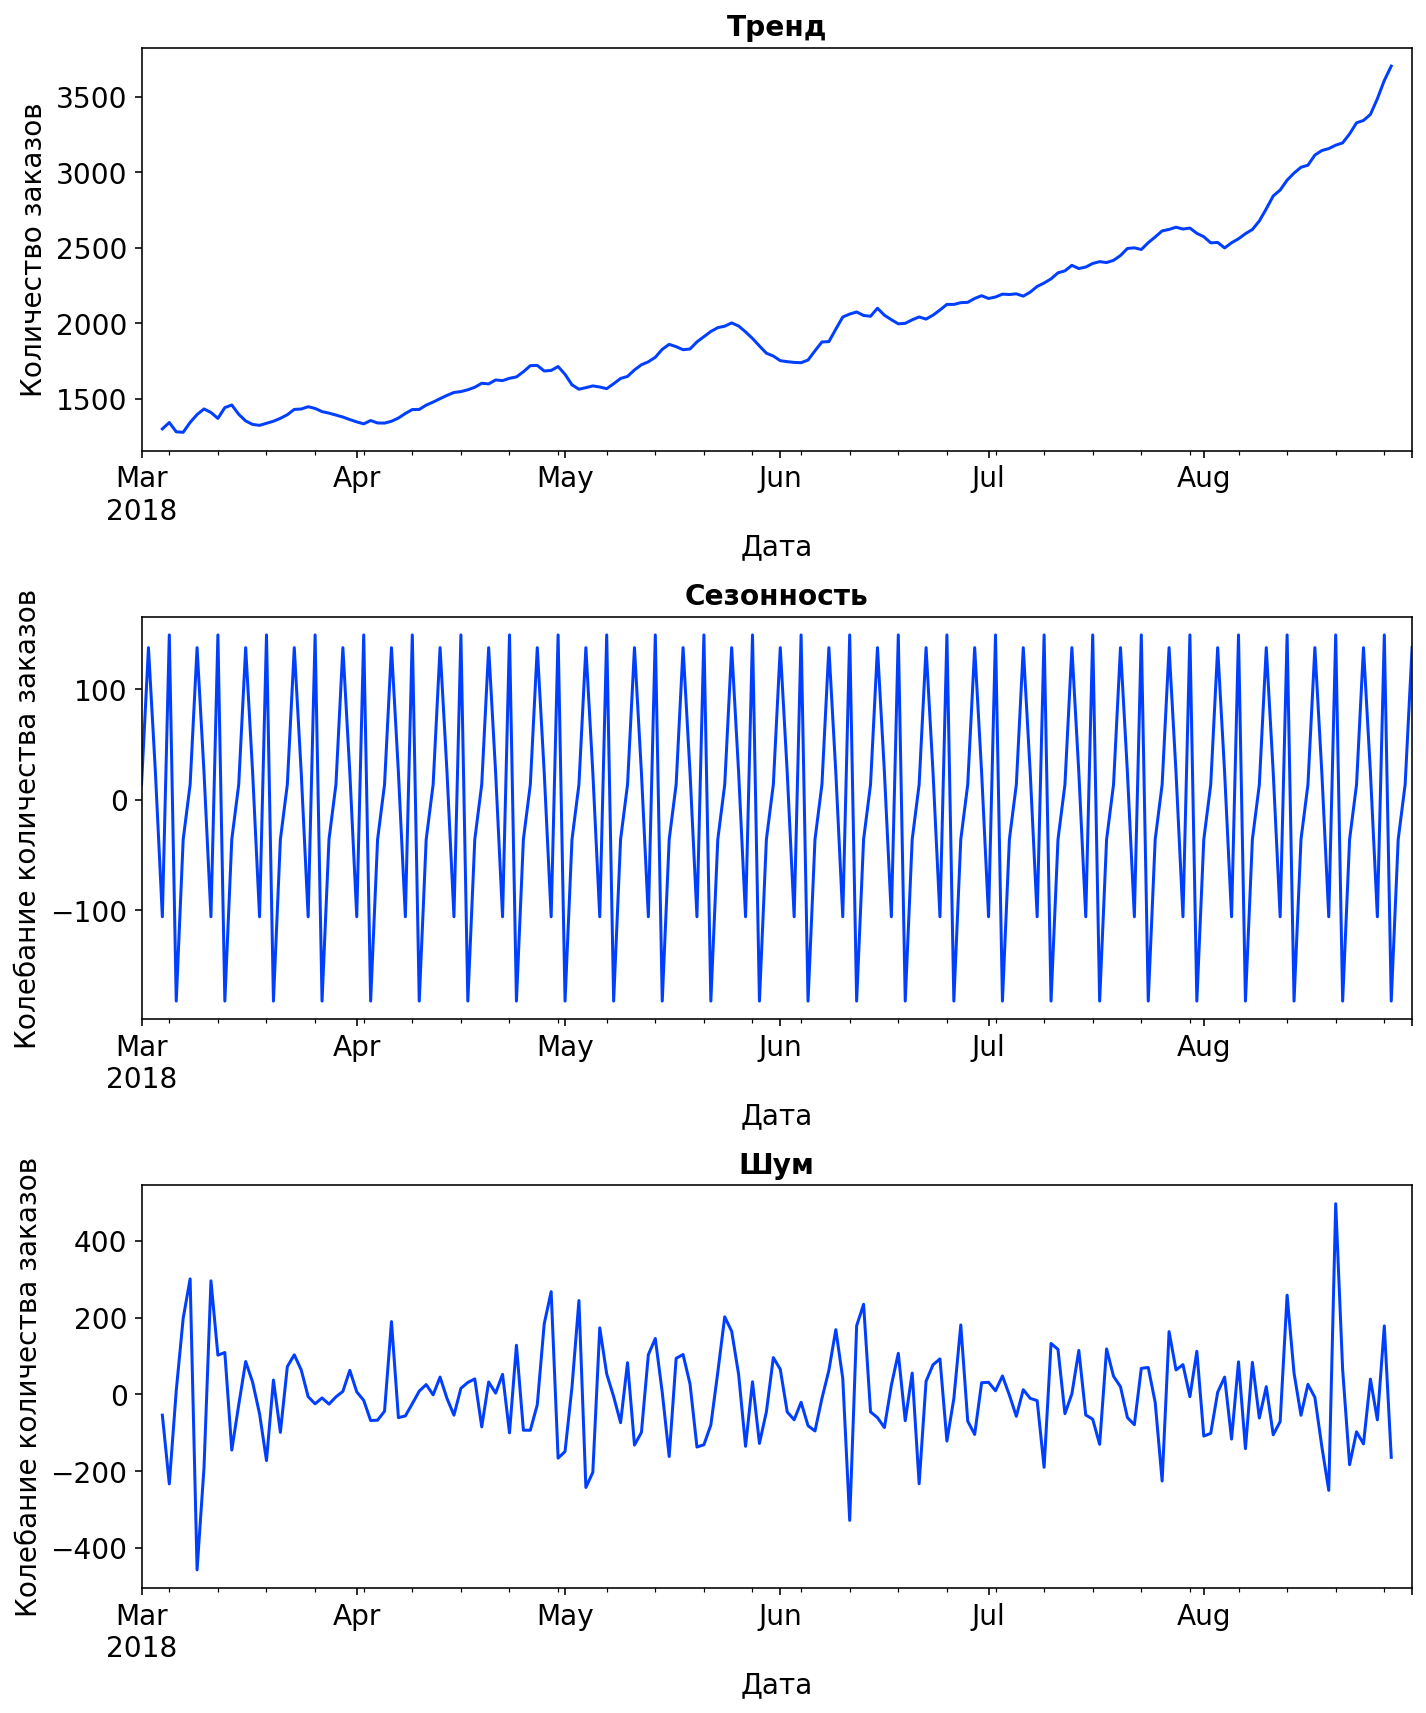

In [ ]:
# ресемплирование данных по одному дню и расчет суммы всех значений в этом интервале
df_day = df.resample('1D').sum()

# разложение временного ряда на тренд, сезонную компоненту и шумы
decomposed = seasonal_decompose(df_day)

plt.figure(figsize=(10, 12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.title('Тренд')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.xlabel('Дата')
plt.ylabel('Колебание количества заказов')
plt.title('Сезонность')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.xlabel('Дата')
plt.ylabel('Колебание количества заказов')
plt.title('Шум')

plt.tight_layout()

График тренда растущий, это значит, что количество вызовов такси в аэропорт с марта по август растет. На графике сезонности наблюдаются колебания с постоянным периодом и амплитудой. Изучим немного детальнее. Посмотрим на промежуток времени в 2 недели.

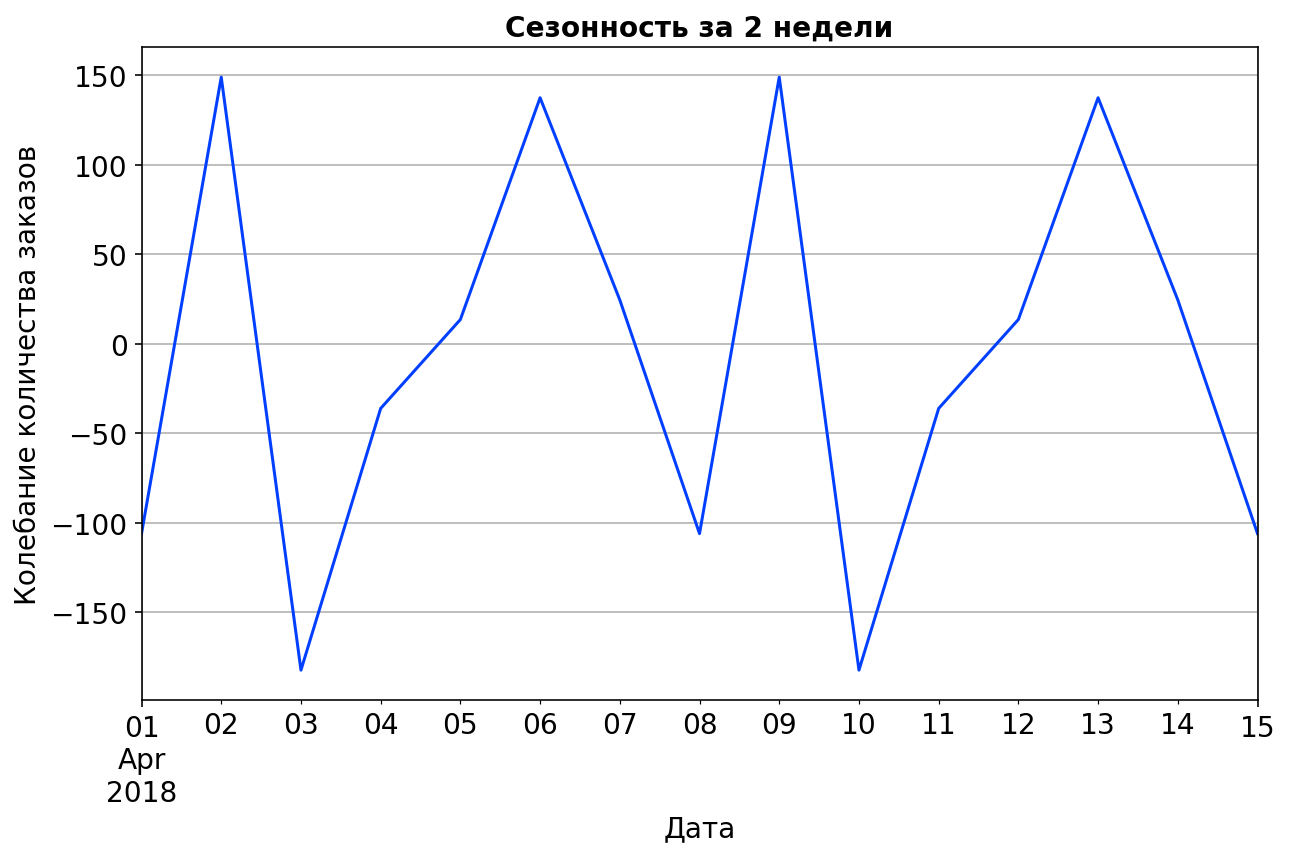

In [ ]:
# построение графика сезонности за первые 2 недели апреля 2018г
plt.figure(figsize=(10, 6))
decomposed.seasonal['2018-04-01':'2018-04-15'].plot()
plt.xlabel('Дата')
plt.ylabel('Колебание количества заказов')
plt.title('Сезонность за 2 недели')
plt.grid(True)

По графику видно, что один период равен одной неделе, в течение которой спрос колеблется и на последующих неделях этот паттерн повторяется.

Добавим новые признаки и узнаем по дням недели как меняется спрос. Год добавлять не будем, т.к. в исходных данных информация только за полгода.

In [ ]:
# добавление новых признаков: день, день недели
df['day'] = df.index.day
df['dayofweek'] = df.index.dayofweek

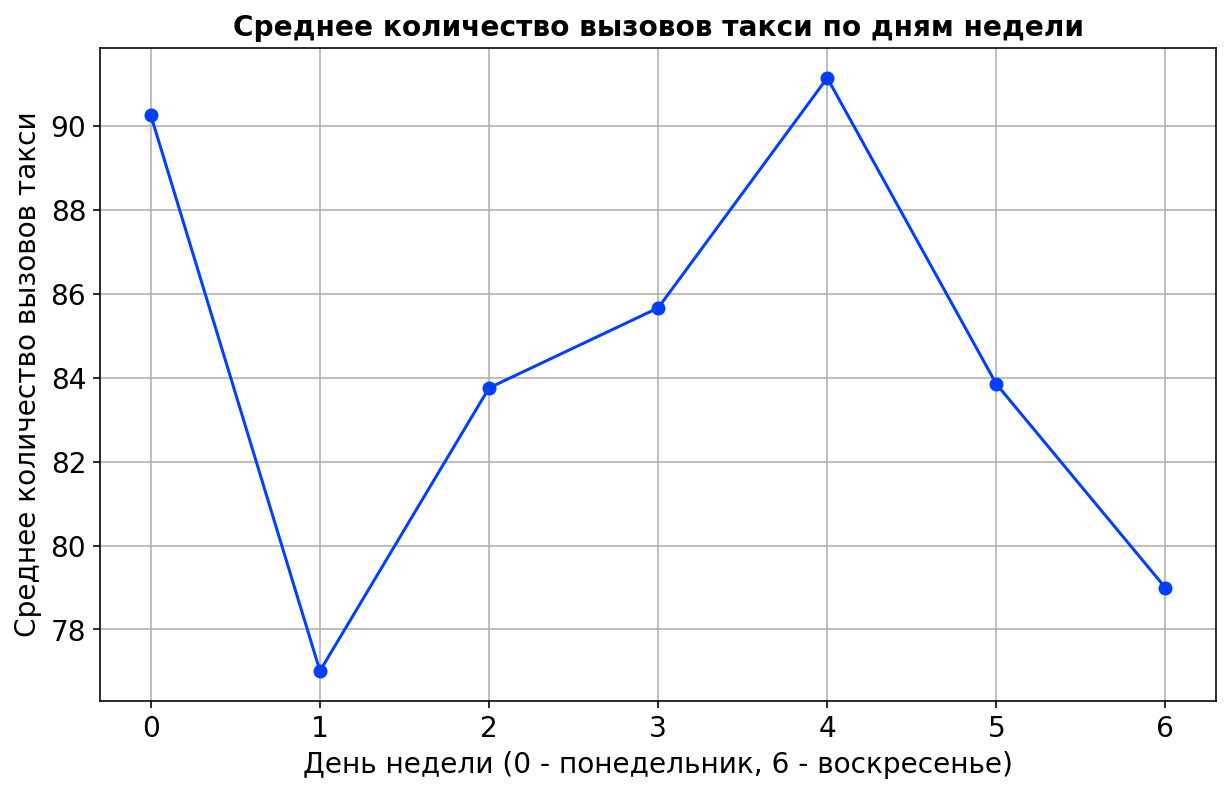

In [ ]:
# построение графика изменения среднего количества заказов в зависимости от дня недели
plt.figure(figsize=(10, 6))
(
    df.groupby('dayofweek').num_orders.mean()
     .plot(grid=True, style='o-')
);

plt.title('Среднее количество вызовов такси по дням недели')
plt.xlabel('День недели (0 - понедельник, 6 - воскресенье)')
plt.ylabel('Среднее количество вызовов такси')
plt.show()

In [ ]:
# получение таблицы со средним количеством вызовов по дням недели
df.groupby('dayofweek').num_orders.mean()

dayofweek
0    90.246795
1    77.011218
2    83.754808
3    85.660494
4    91.140432
5    83.847756
6    78.991987
Name: num_orders, dtype: float64

По полученному графику видно, что количество заказов зависит от дня недели. С понедельника на вторник количество заказов резко снижается со среднего количества 90 заказов до 77. Затем постепенно растет достигая пикового значения в пятницу в 91 заказ/день. Далее к выходным количество снова уменьшается, чтобы вновь в понедельник вырасти до 90 заказов. Такие колебания обясняются тем, что многие предпочитают по возможности удлиннять свой отдых, поэтому выбирают вылеты в пятницу и прилеты по понедельникам.

Посмотрим также на колебание спроса в течении дня.

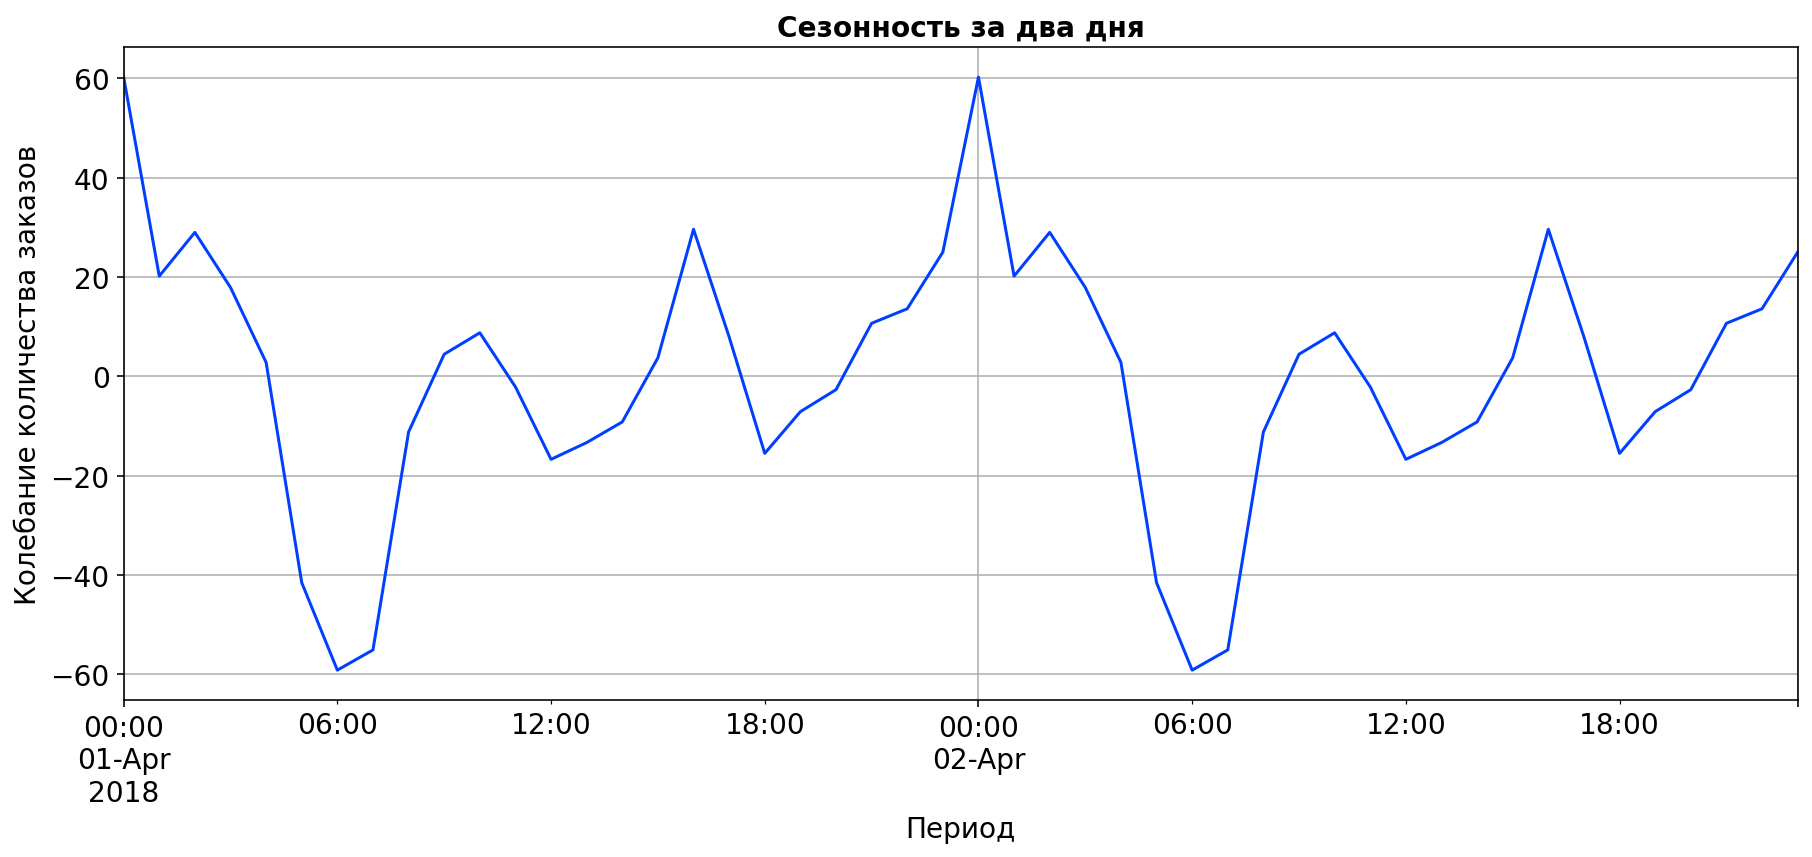

In [ ]:
# построим график сезонности за два дня
decomposed = seasonal_decompose(df['num_orders'])

plt.figure(figsize=(15, 6))

decomposed.seasonal['2018-04-01':'2018-04-02'].plot(ax=plt.gca())
plt.title('Сезонность за два дня')
plt.xlabel('Период')
plt.ylabel('Колебание количества заказов')
plt.grid(True)

In [ ]:
# получение таблицы со средним количеством вызовов за каждый час
df.groupby(df.index.hour).num_orders.mean()

datetime
0     144.402174
1     104.364130
2     113.070652
3     102.021739
4      86.907609
5      42.630435
6      25.173913
7      29.271739
8      73.048913
9      88.831522
10     93.119565
11     82.489130
12     67.630435
13     71.173913
14     75.163043
15     87.945652
16    114.146739
17     92.722826
18     69.358696
19     77.336957
20     81.858696
21     95.211957
22     98.500000
23    109.766304
Name: num_orders, dtype: float64

Пиковые нагрузки наблюдаются в 00:00, достигая в среднем 145 заказов/час. Также присутствуют локальные пики в 2 часа ночи (113 заказов/час), в 10 утра (93 заказа/час), в 4 часа дня (114 заказов/час). Наименьшее количество заказов в 6 утра равное в среднем 25 заказам/час. Данная картина хорошо отражает реальность: наибольший спрос наблюдается в ночное время, когда другой общественный транспорт ходит реже, а пассажиры поскорее хотят попасть к себе домой. Наибольшее количество рейсов как правило приходится на дневное время, тем не менее в это время часть пассажиров выбирают другие виды транспорта, поэтому в дневное время наблюдается чуть меньший спрос на такси. В 6 утра наблюдается минимальный спрос на такси, т.к. в такое ранее время как правило меньше вылетов/прилетов и они более бюджетные, поэтому и пассажиры, которые выбирают такое время, также предпочитают более бюджетные виды транспорта.

Проверим имеющийся временной ряд на стационарность. Для начала оценим ее по графику скользящей средней, а затем проведем тест Дики-Фуллера.

In [ ]:
# добавление признака скользящее среднее в окне равном 14 дней
df_day['rolling_mean_14'] = df_day['num_orders'].shift().rolling(14).mean()
df_day['std'] = df_day['num_orders'].shift().rolling(14).std()

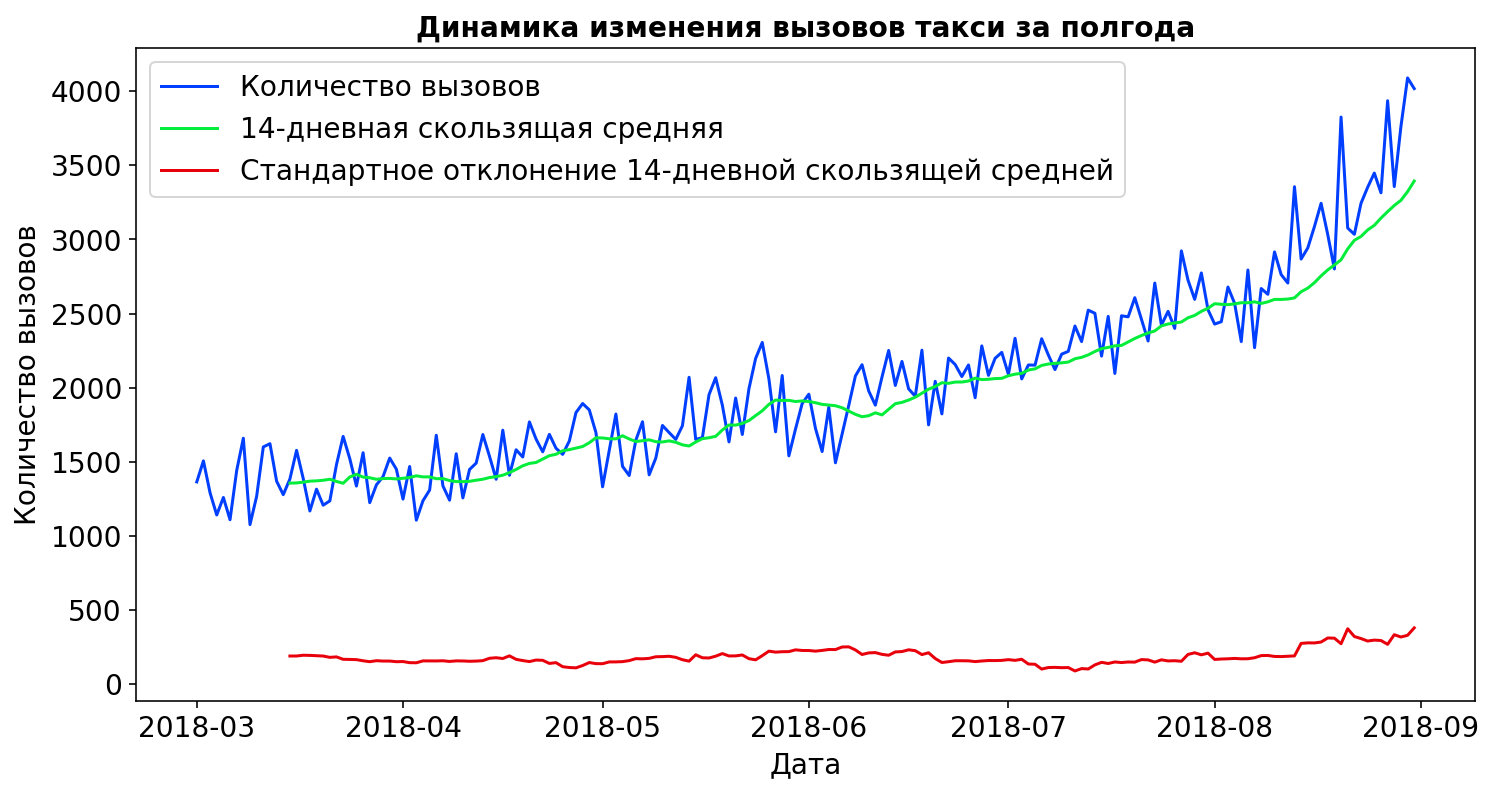

In [ ]:
# вывод графика дневного количества вызовов и 14-дневного скользящего среднего
plt.figure(figsize=(12, 6))
plt.plot(df_day['num_orders'] , label='Количество вызовов')
plt.plot(df_day['rolling_mean_14'] , label="14-дневная скользящая средняя")
plt.plot(df_day['std'] , label="Стандартное отклонение 14-дневной скользящей средней")
plt.title("Динамика изменения вызовов такси за полгода")
plt.xlabel("Дата")
plt.ylabel("Количество вызовов")
plt.legend()
plt.show()

Скользящая средняя за 14 дней на графике помогает увидеть общий тренд и сгладить ежедневные колебания спроса на такси. В целом прослеживается растущий тренд и средняя растет вместе с ростом ежедневных колебаний. График стандартного отклонения показывает практически неизменное значение, значит дисперсия практически неизменна.
Таким образом, исходный датасет имеет изменяющееся во времени среднее и относительно постоянное стандартное отклонение, поэтому он не может считаться стационарным. Скорее всего не хватает данных, т.к. в наличии только данные за полгода, а с марта по август заведомо растет спрос на вызовы такси в аэропорт в связи с летними отпусками, то не хватает данных по спаду спроса осенью и после новогодних праздников.

Теперь проверим исходные данные на стационарность с помощью теста Дики-Фуллера. Он заключается в подтверждении или отклонении двух гипотез:

Нулевая гипотеза (H0): предполагает, что временной ряд имеет единичный корень, то есть он нестационарный.

Альтернативная гипотеза (H1): предполагает, что временной ряд не имеет единичного корня, то есть он является стационарным.

Для подтверждения или опровержения этих гипотез сравним значение p-value с с уровнем значимости alfa.

В случае если p–values больше значения alfa, то мы отвергаем нулевую гипотезу, и, следовательно, ряд является стационарным, имеет определенную периодичность, которую возможно выявить.

In [ ]:
result = adfuller(df['num_orders'], autolag = 'AIC')

print('Критерий ADF: %f' % result[0])

print('P-значение: %f' % result[1])

print('Критические значения:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

    if result[0] > result[4][key]:
        print ("Нулевая гипотеза не отвергнута – Временной ряд не стационарен")
    else:
        print ("Нулевая гипотеза отвергнута – Временной ряд стационарен")

NameError: name 'adfuller' is not defined

Тест Дики-Фуллера показал, что исследуемый временной ряд является нестационарным при уровне значимости 1% и стационарным при уровнях значимости 5 и 10%.     

<font size="4"><b>Выводы по этапу анализа данных:</b></font>

- Наблюдается растущий тренд спроса заказов с марта по август.
- Количество заказов зависит от дня недели и часа дня. Пиковые нагрузки наблюдаются по четвергам и в 00:00. Минимальное количество заказов по вторникам и в 6 утра.
- Год и месяц в моделировании использовать не будем, т.к. в исходных данных информация только за полгода.

## Обучение

На данном этапе обучим три модели: LinearRegression, DesisionTreeRegressor и LightGBM.

Опытным путем обнаружили, что величина окна для скользящего среднего влияет на метрику в меньшей степени, чем максимальный размер отставания (max_lag), поэтому зафиксируем rolling_mean_size равным 24 часам, а на модели LinearRegression проведем подбор оптимальной величины максимального отставания.

Напишем функции для добавления новых признаков: отстающих значений и скользящего среднего в датасет, а также split_data для разделения датасета на обучающую и тестовую выборки.

In [ ]:
# функция для добавления в датафрейм
# отстающих значений, размер и количество которых соответствует max_lag,
# и скользящего среднего
def choose_lag(data, max_lag, rolling_mean_size):
    data = data.copy()

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [ ]:
# функция для разделения датафрейма на обучающую и тестовую выборку
# размер тестовой выборки 10%, перемешивание данных отключено
def split_data(data):
    # разделение исходных данных на обучающую и тестовую
    train, test = train_test_split(data, shuffle=False, test_size=0.1)
    train = train.dropna()

    y_train = train['num_orders']
    X_train = train.drop('num_orders', axis=1)

    y_test = test['num_orders']
    X_test = test.drop('num_orders', axis=1)

    return y_train, X_train, y_test, X_test

### Модель LinearRegression

На модели линейной регрессии подберем оптимальную величину max_lag, которую будем использовать и для последующих моделей. Кросс-валидацию будем делать с помощью TimeSeriesSplit, который сохраняет временную последовательность ряда.

In [ ]:
# список временных промежутков, среди которых будет вестись поиск оптимального max_lag
period = [12, 24, 36, 48, 60, 72, 84]

max_lag_list = []
rmse_lr_list = []

# цикл для подбора оптимального значения max_lag
for max_lag in period:
    df_with_f = choose_lag(df, max_lag, 24)

    y_train, X_train, y_test, X_test = split_data(df_with_f)

    # инициализация модели
    model_lr = LinearRegression()

    # создание объекта-генератора разбиений для временного ряда с числом фолдов равным 5
    tscv = TimeSeriesSplit(n_splits=5)

    # получение среднего значения RMSE на кросс-валидации
    rmse_lr = cross_val_score(model_lr, X_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error').mean()*(-1)

    # добавление метрики RMSE и соответствующей ей величине max_lag в список
    max_lag_list.append(max_lag)
    rmse_lr_list.append(rmse_lr)

# создание датафрейма с полученными значениями
result_lr = pd.DataFrame({
                        'max_lag': max_lag_list,
                        'rmse_lr': rmse_lr_list
})

# создание пустого списка и добавление в него лучшей метрики RMSE для модели линейной регрессии
rmse_train = []
rmse_train.append(min(rmse_lr_list))

print(f"Наилучший RMSE и его max_lag: \n\n {result_lr[result_lr['rmse_lr'] == result_lr['rmse_lr'].min()]}")

Наилучший RMSE и его max_lag: 

    max_lag    rmse_lr
5       72  24.105472


Таким образом, подобрали максимальную величину отставания (max_lag), оптимальным оказалось значение равное 24 ч. Значение метрики RMSE при этом оказалось равным 27 заказов.

Посмотрим на размерность получившихся обучающей и тестовой выборки.

In [ ]:
# сохранение датафрейма с оптимальными max_lag и rolling_mean_size
df = choose_lag(df, 24, 24)

# разделение на обучающую и тестовую выборку
y_train, X_train, y_test, X_test = split_data(df)
print(f"Размер обучающей выборки: {X_train.shape}, {y_train.shape},\n тестовой выборки: {X_test.shape}, {y_test.shape}")

Размер обучающей выборки: (3950, 27), (3950,),
 тестовой выборки: (442, 27), (442,)


### Модель DecisionTreeRegressor

In [ ]:
# задание гиперпараметров модели DecisionTreeRegressor
param = {
    'max_depth': [None, 15, 30],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [2, 5]
}

# запуск автоматического подбора параметров с помощью GridSearchCV
grid_search = GridSearchCV(
                            DecisionTreeRegressor(random_state=42),
                            param,
                            scoring='neg_root_mean_squared_error',
                            cv=tscv)

grid_search.fit(X_train, y_train)
model_dtr = grid_search.best_estimator_
rmse_dtr = grid_search.best_score_*(-1)

rmse_train.append(rmse_dtr)

print('Лучшая модель и её параметры:\n\n', model_dtr)
print (f"Метрика лучшей модели на кросс-валидации RMSE = {rmse_dtr:.0f} заказов")

Лучшая модель и её параметры:

 DecisionTreeRegressor(min_samples_leaf=5, random_state=42)
Метрика лучшей модели на кросс-валидации RMSE = 33 заказов


### Модель LightGBM

In [ ]:
# передадим словарь с параметрами для LightGBM моделирования
params = {'learning_rate': [0.05],
              'n_estimators': [100, 150],
              'num_leaves': [25, 35],
              'min_child_samples': [1],
              'colsample_bytree': [0.9]
}

# инициализируем модель LGBMRegressor
model = lgb.LGBMRegressor(objective='regression', random_state=42)

grid_search = GridSearchCV(model,
                          params,
                          verbose = 1,
                          cv = tscv,
                          scoring='neg_root_mean_squared_error',
                          n_jobs = -1)

# запуск поискa  лучших гиперпараметров
grid_search.fit(X_train, y_train)

# сохраняем лучшую модель и её метрику
lgbm_model = grid_search.best_estimator_
rmse_lgbm = grid_search.best_score_ * (-1)

rmse_train.append(rmse_lgbm)

print('Лучшая модель и её параметры:\n\n', lgbm_model)
print (f'Метрика лучшей модели на кросс-валидации: {rmse_lgbm:.2f}')

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Лучшая модель и её параметры:

 LGBMRegressor(colsample_bytree=0.9, learning_rate=0.05, min_child_samples=1,
              n_estimators=150, num_leaves=25, objective='regression',
              random_state=42)
Метрика лучшей модели на кросс-валидации: 25.51


## Тестирование


Соберем все метрики RMSE, оцененные на кросс-валидации по всем моделям в датафрейм.

In [ ]:
result = pd.DataFrame(
    {
    "Модель": ['LinearRegression', 'DecisionTreeRegressor', 'LightGBM'],
    "RMSE на cv": rmse_train
    }
)

result

,Модель,RMSE на cv
0,LinearRegression,24.105472
1,DecisionTreeRegressor,32.717686
2,LightGBM,25.511570


Модель LightGBM показала наилучшую метрику RMSE на кросс-валидации. Ее RMSE оказалось равным 26 заказов. Ее и будем использовать для получения предсказаний на тестовых данных.

In [ ]:
# модель LightGBM
# обучим модель на тренировочных данных
lgbm_model.fit(X_train, y_train)

# получение прогнозных значений на тестовых данных
y_pred_lgbm = lgbm_model.predict(X_test)

# расчет RMSE для модели LightGBM
rmse_lgbm_test = mse(y_test, y_pred_lgbm, squared=False)

#rmse_test.append(rmse_lgbm_test)

RMSE модели LightGBM на тестовых данных оказалась равной 42 заказа, т.е. модель в среднем ошибается в предсказаниях на 42 заказа и она проходит по критерию значение метрики RMSE на тестовой выборке не больше 48.

Параметры лучшей модели LightGBM: colsample_bytree=0.9, learning_rate=0.05, min_child_samples=1, n_estimators=150, num_leaves=25, objective='regression', random_state=42.

Посмотрим на графике как выглядят прогнозные и реальные данные выбранной модели.

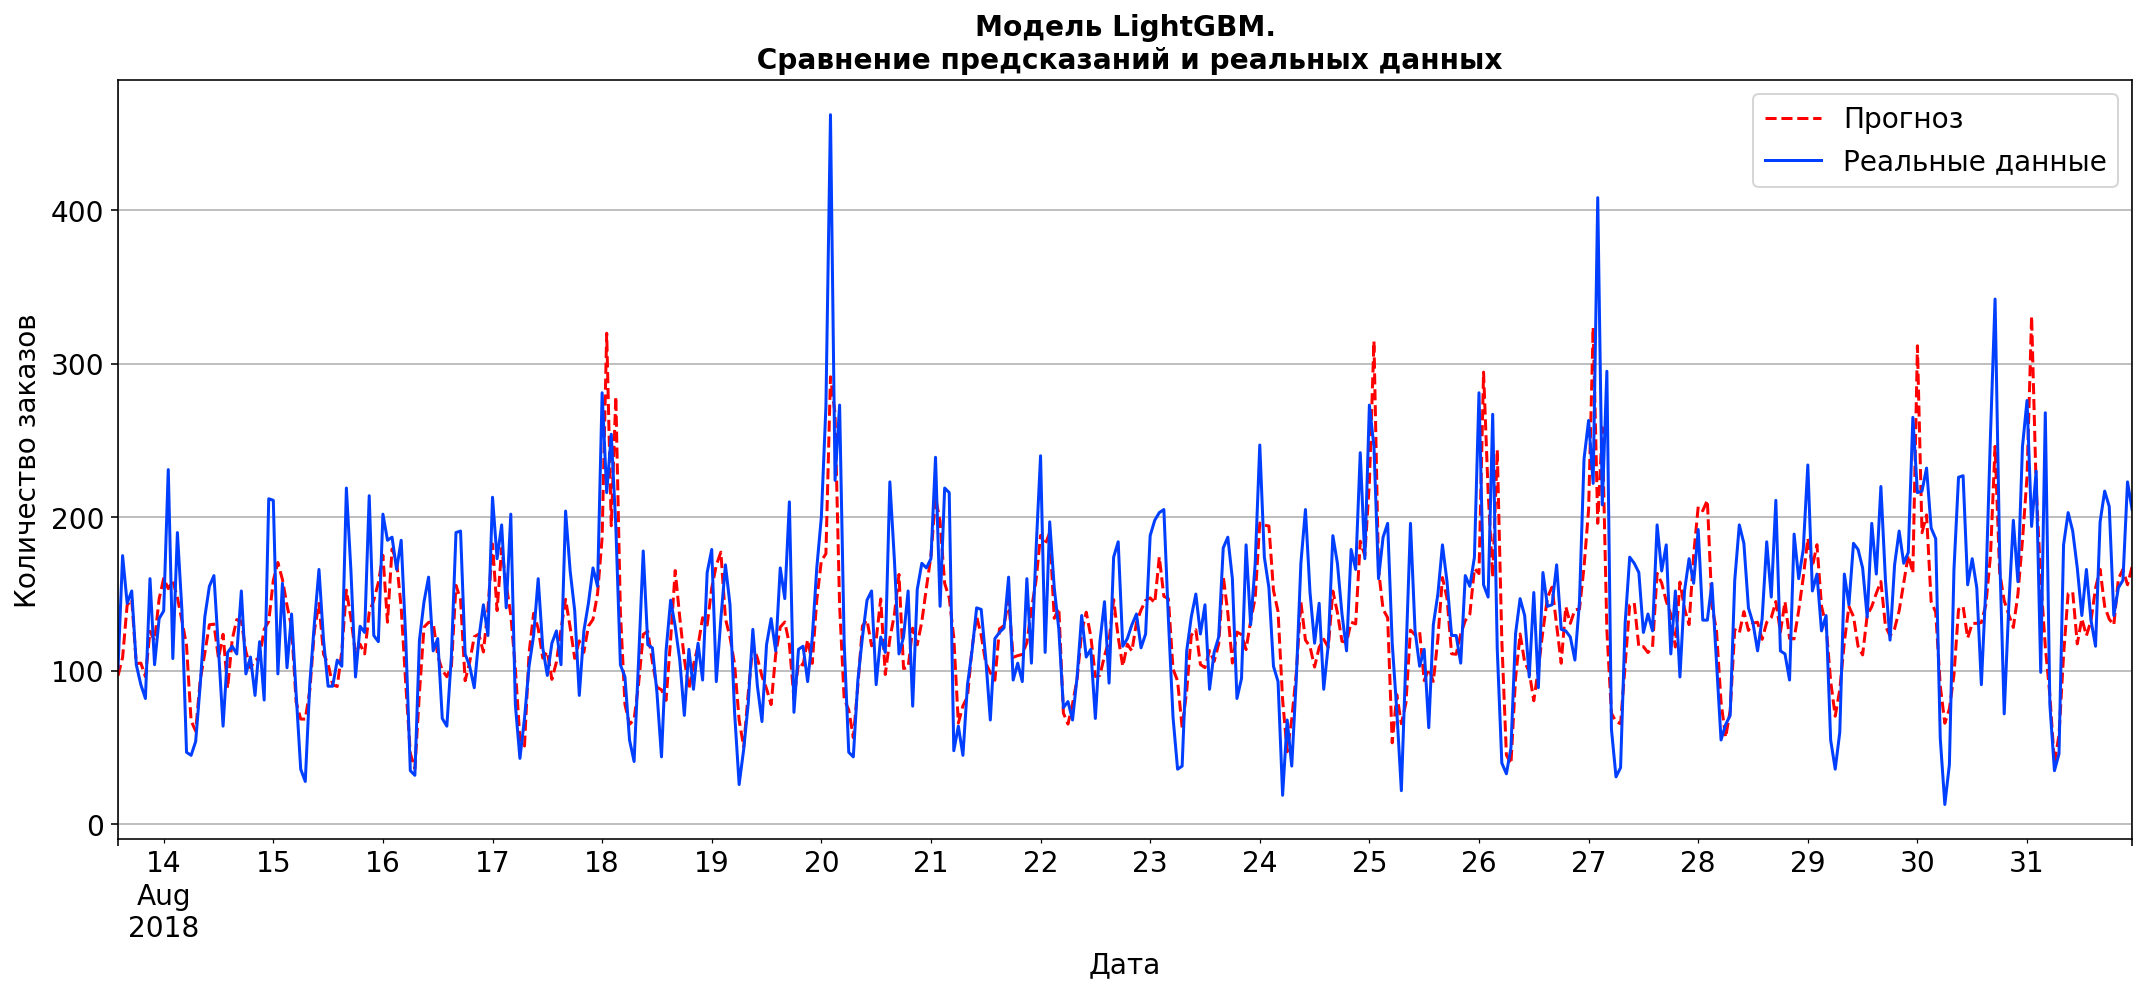

In [ ]:
# создание датафрейма из прогнозов модели LightGBM
y_pred_lgbm = pd.DataFrame(y_pred_lgbm, index=y_test.index)
y_pred_lgbm.columns = ['Прогноз']

# построение графика прогнозных и реальных значений
plt.figure(figsize=(15, 7))
y_pred_lgbm.plot(ax=plt.gca(), color='r', ls='--')
y_test.plot(ax=plt.gca(), label='Реальные данные')
plt.title('Модель LightGBM.\n Сравнение предсказаний и реальных данных')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.grid(True)
plt.legend(loc="best")
plt.tight_layout()

По графику видно, что выбранная модель в целом хорошо прогнозирует характер изменения спроса, но в большинстве случаев недооценивает локальные минимумы и максимумы значений.

In [ ]:
# создание и обучение модели DummyRegressor
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(X_train, y_train)

# предсказание на тестовых данных
dummy_model_preds = dummy_model.predict(X_test)

# расчет RMSE для модели DummyRegressor
rmse_dummy_test = mse(y_test, y_pred_lgbm, squared=False)
print(f'Метрика RMSE на тестовой выборке дамми-модели:  {rmse_dummy_test:.2f}')

Метрика RMSE на тестовой выборке дамми-модели:  43.60


RMSE метрика на дамми-модели оказалась чуть хуже, чем на выбранной модели LightGBM. Дамми модель ошибается в среднем на 44 заказа, в то время как LightGBM - на 42.


## Вывод

В ходе данного проекта были изучены данные компании «Чётенькое такси», которое занимается перевозкой пассажиров.

Для начала данные были загружены и ресемплированы по одному часу. В ходе **предварительного обзора** данных было выяснено, что:
- Названия столбцов менять не надо.
- В данных 26496 строчек и 1 столбец.
- Пропусков нет.
- Тип данных преобразовывать не надо.
- Дата и время расположены в хронологическом порядке.
- Имеются данные за полгода за период с 2018-03-01 00:00:00 до 2018-08-31 23:50:00.

На этапе **анализа данных** было выявлено:
- Наблюдается растущий тренд спроса заказов с марта по август.
- Количество заказов зависит от дня недели и часа дня. Пиковые нагрузки наблюдаются по четвергам и в 00:00. Минимальное количество заказов по вторникам и в 6 утра.
- Год и месяц в моделировании использовать не будем, т.к. в исходных данных информация только за полгода.
- Исходные данные были также проверены на стационарность. График 14-дневного скользящего среднего и его стандартного отклонения показал относительное постоянство дисперсии, но изменение среднего, что свидетельствует о нестационарности. Однако проведенный тест Дики-Фуллера показал его стационарность.

На этапе **обучения** были обучены 3 модели: LinearRegression, DesisionTreeRegressor и LightGBM.
На модели линейной регрессии было подобрано оптимальное значение максимального размера отставания (max_lag). Оно равно 24 часа. Также во входные признаки было добавлено скользящее среднее, рассчитанное в окне 24 часа. Все эти признаки использовались для всех моделей.
С помощью инструмнта кросс-валидации TimeSeriesSplit, который сохраняет временную последовательность данных, были подобраны оптимальные гиперпараметры для всех моделей и рассчитаны метрики RMSE.

На этапе **тестирования** модель LightGBM была выбрана для получения предсказаний на тестовой выборке, т.к. показала наилучшую метрику при кросс-валидации (RMSE = 26 заказов). RMSE модели LightGBM на тестовых данных оказалась равной 42 заказа, т.е. модель в среднем ошибается в предсказаниях на 42 заказа и она проходит по критерию значение метрики RMSE на тестовой выборке не больше 48. **Ее параметры: colsample_bytree=0.9, learning_rate=0.05, min_child_samples=1, n_estimators=150, num_leaves=25, objective='regression', random_state=42.**

По графику прогнозных и реальных значений видно, что выбранная модель в целом хорошо прогнозирует характер изменения спроса, но в большинстве случаев недооценивает локальные минимумы и максимумы значений.

Сравнение модели LightGBM с константной также показало лучшие метрики.

**Рекомендация: Добавить информацию хотя бы еще за полгода, для того, чтобы проследить сезонные колебания спроса.**